In [1]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Necessary functions

function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)
      
    al=0
    
    if(abs(x-y)<t)         
         al=exp(-((x-y)^2)/(omega^2))
         #denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
         #al/=denom
    end
    return al
end

function alpha_tri(x::Float64, y::Float64, slope::Float64, t::Float64)
    
    alpha=0.0
    
    if ( abs(x-y) < t) 
        
        alpha=1- (slope*abs(x-y))
        
    end
        
    return max(0,alpha)
    
end
    

function mc_gt(x::Vector{Float64},y::Vector{Float64},omega::Float64, t::Float64)
    
    res=0
    
    for i in 1:10^6
        
        x1=sample(x)
        y1=sample(y)
        
        res+=(mean(x)-x1)*alpha_gt(x1,y1,omega,t)
        
    end
    return res/(10^6)
    
end

function mc_tri(x::Vector{Float64},y::Vector{Float64},slope::Float64, t::Float64)
    
    res=0
    
    for i in 1:10^6
        
        x1=sample(x)
        y1=sample(y)
        
        res+=(mean(x)-x1)*alpha_tri(x1,y1,slope,t)
        
    end
    return res/(10^6)
    
end

function qgprob(n::Int64)

    #All possible phenotypes
    pheno= collect(1:(2*n+1)) ./ (2*n+1)
    nt=length(pheno)

    G=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                m=collect(0:min(j,k,i+j-k))
                G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
    end

    for k in 0:n
        G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
        for i1 in 0:n
            G[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
             ind_haplR[1+i,1+k] = G[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
         R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .*
                             ind_haplR[1+j,1+q .- (0:q)])
    end

    return R
end



function single_sim(nsp,A1,A0,R, Ng0, Npop)
    
        Np0=Ng0 .*Npop
        Ngen=deepcopy(Ng0)
        Np=deepcopy(Np0)
    
        dat=zeros(Float64,1000,nsp,nt)
        
        #Start the simulation
        for m in 1:1000
    
            #Determine the extinct species
            Np[findall(sum(Np,dims=2) .< 10),:] .= 0
            Ngen[findall(sum(Np,dims=2).==0),:] .= 0

            if all(sum(Np,dims=2) ==0) 
                break
            else

                newgen=zeros(Float64,nsp,nt)

                #Reproduction event
                for i in 1:size(Ngen)[1]

                    probs=Ngen[i,:]*Ngen[i,:]'

                    for j in 1:size(R)[3]
                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end
                end

                newp=newgen .* sum(Np,dims=2)

                #Selection event

                for i in 1:size(newp)[1], j in 1:size(newp)[2]

                    comps=sum(A1[j,:] .* newp[1:end .!=i,:]') + sum(A0[j,:] .* newp[i,:]) 
                    Np[i,j]=newp[i,j]*r[i]*(1-comps)
                    #Np[i,j]=newp[i,j]+(newp[i,j]*(1-comps))

                end

                Np[findall(Np .<1)] .= 0
                Ngen= Np ./ sum(Np,dims=2)
                Ngen[isnan.(Ngen)].=0
            end
            
        dat[m,:,:]=Np
            
        end
    
    return dat
    
end
        
    


single_sim (generic function with 1 method)

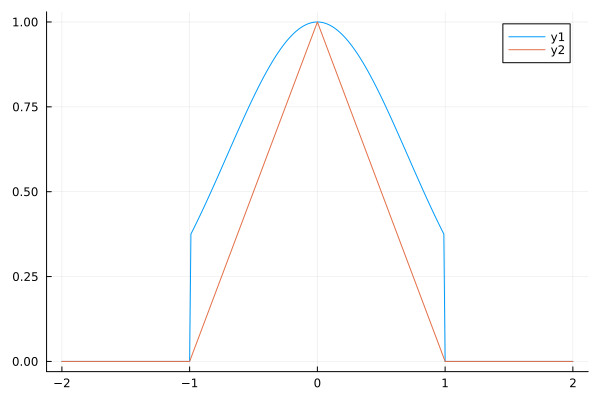

In [2]:
x=0.0
y=collect(-2.0:0.01:2.0)

res=[alpha_gt(x,y[i],1.0,1.0) for i in 1:length(y)]

res2=[alpha_tri(x,y[i],1.0,1.0) for i in 1:length(y)]

plot(y,res)

plot!(y,res2)



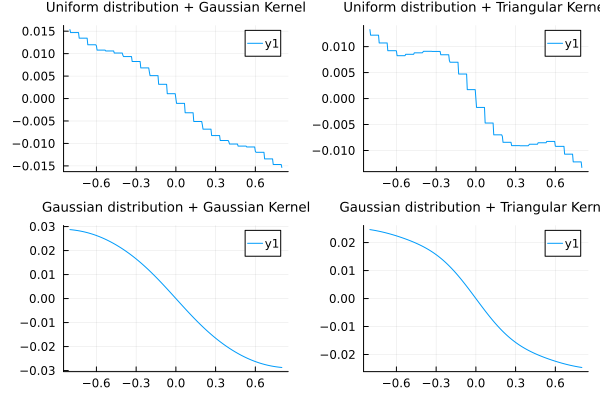

In [4]:
########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################

n=15
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.0
slope=0.63
t=1.0
a1=0.5

#Set the mean trait value for species no. 2
means=collect(-0.8:0.005:0.8)

#Pre-calculate coefficients of competition between pairs of phenotypes

A0g=zeros(Float64,nt,nt)
A0t=zeros(Float64,nt,nt)


for i1 in 1:nt, i2 in 1:nt
    
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

A1t=0.5 .* A0t

A1g= 0.5 .*A0g

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas1=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)
    
end


p1=plot(means,betas1,title="Uniform distribution + Gaussian Kernel",titlefont=font(9))


########################################################################################################
#Case 2: Gaussian distributed traits + truncated gaussian comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas2[i]=sum(newfreq .* geno)
    
end

p2=plot(means,betas2,title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

########################################################################################################
#Case 3: Gaussian distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas3=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas3[i]=sum(newfreq .* geno)
    
end

p3=plot(means,betas3,title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

########################################################################################################
#Case 4: Uniformly distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas4=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas4[i]=sum(newfreq .* geno)
    
end

p4=plot(means,betas4,title="Uniform distribution + Triangular Kernel",titlefont=font(9))

plot(p1,p4,p2,p3, layout = (2,2))

In [ ]:
#Run the long term simulations with different parameter combinations

  nsp=20
  n=10

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=1.0
    t=1.0
    a1=0.15
    r=abs.(rand(Uniform(1.0,1.1),nsp))

    #Pre-calculate coefficients of competition between pairs of phenotypes

    A0g=zeros(Float64,nt,nt)
    A0t=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end

    A1t=a1 .* A0t

    A1g= a1 .*A0g

    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.8,0.8),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.2,rands[i]+0.2),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2)



    ########################################################################################################
    #Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1g ./10000

    A0=A0g ./10000

    result=single_sim(nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p21=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Uniform distribution + Gaussian Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]



    ########################################################################################################
    #Case 2:  Gaussian distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_gau

    A1=A1g ./10000

    A0=A0g ./10000

    result=single_sim(nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p22=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]


    ########################################################################################################
    #Case 3:  Gaussian distributed traits + Triangular comp. kernel
    ########################################################################################################
    Ng0=N_gau

    A1=A1t ./10000

    A0=A0t ./10000

    result=single_sim(nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p23=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]


    ########################################################################################################
    #Case 4:  Uniformly distributed traits + Triangular comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1t ./10000

    A0=A0t ./10000

    result=single_sim(nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p24=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Uniform distribution + Triangular Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]



    plot(p21,p24,p22,p23, layout = (2,2))
                        



